## Step 0: Image Processing

# Image Processing and Captioning Pipeline with AWS Services

### Introduction

Welcome to this comprehensive notebook on Image Processing and Captioning Pipeline with AWS Services. This notebook demonstrates a sophisticated approach to handling, processing, and analyzing images using cutting-edge cloud technologies and artificial intelligence.


In today's digital ecosystem, image captioning represents far more than a simple description of visual content—it stands as a crucial bridge between visual and textual information, fundamentally transforming how we interact with and derive value from digital imagery. At its core, image captioning serves as an essential accessibility tool, enabling visually impaired users to comprehend visual content through screen readers and assistive technologies. However, its significance extends well beyond accessibility, playing a pivotal role in for our use case of customizing a video generation model.

The implementation of advanced image captioning, particularly through sophisticated AI models like Claude-3, addresses several critical challenges in modern digital content management. By generating detailed, contextually aware descriptions, these systems enable powerful semantic search capabilities, allowing users to locate specific images based on natural language queries rather than relying solely on manually tagged metadata. This capability has profound implications for large-scale digital asset management, where manual captioning would be both time-prohibitive and cost-ineffective.


In today's digital landscape, the ability to efficiently process and analyze large volumes of images has become increasingly crucial. This notebook leverages several powerful AWS services, including:

* **Amazon Bedrock** with Claude-3 for intelligent image analysis
* **Amazon S3** for scalable storage
* **Amazon SageMaker** for notebook hosting

Our pipeline implements a *multi-stage approach* that transforms raw images into searchable, analyzable assets while maintaining high performance and scalability.

### Key Features:

* **Automated Processing Pipeline**:
  * Bulk image processing
  * Intelligent resizing and optimization
  * Base64 encoding for API compatibility
  * S3 storage of images

* **AI-Powered Analysis**:
  * Advanced image description generation
  * Content-based image understanding
  * Multi-modal AI integration

* **Robust Data Management**:
  * Efficient storage organization
  * Metadata extraction and indexing

## Table of Contents
1. [Setup and Dependencies](#Setup-and-Dependencies)
2. [Configuration and Initialization](#Configuration-and-Initialization)
3. [Directory Management](#Directory-Management)
4. [Display and Upload Images](#Display-and-Upload-Images)
5. [Image Processing and Encoding](#Image-Processing-and-Encoding)
5. [Image Description Generation](#Image-Description-Generation)
6. [Results Visualization](#Results-Visualization)

***

## Setup and Dependencies

In [ ]:
!pip install -r requirements.txt

In [2]:
from typing import List, Tuple, Optional
import json
import boto3
import os
import base64
import shutil
from io import BytesIO
from tqdm import tqdm
import sagemaker
from sagemaker import get_execution_role
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from PIL import Image

sagemaker_session = sagemaker.Session()
sagemaker_role_arn = get_execution_role()
REGION = sagemaker_session.boto_region_name
bedrock_client = boto3.client("bedrock-runtime", REGION)
%store REGION

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[02/09/25 14:27:32] INFO     Found credentials from IAM Role:                                   ]8;id=628138;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=800315;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


                    INFO     Found credentials from IAM Role:                                   ]8;id=14219;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=840801;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[02/09/25 14:27:33] INFO     Found credentials from IAM Role:                                   ]8;id=927271;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=420887;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=622829;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=416115;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Stored 'REGION' (str)


<div class="alert alert-block alert-info">
<b>Note:</b> Make sure all dependencies are installed before proceeding. You may need to restart your kernel if an error occurs. This notebook requires AWS credentials with appropriate permissions if not running on a SageMaker notebook.
</div>

### Enable Amazon Bedrock Models

  * Go to the [Amazon Bedrock model access page](https://us-east-1.console.aws.amazon.com/bedrock/home?region=us-east-1#/modelaccess)
  * Select "Modify model access" or "Enable Specific Models"

  ![Model Access](assets/model_access.png)
  * Under Amazon select "Nova Reel"

  ![Select Nova Reel](assets/select_nova_reel.png)
  * Select "Next" and then "Submit"

***

## Configuration and Initialization

What this section does:
1. Retrieves configuration from AWS Systems Manager
2. Sets up essential variables for the pipeline
3. Validates all required parameters are present

Important Variables:
- stack_name: Your CloudFormation stack name
- COLLECTION_ID: Identifier for image collection
- BUCKET: S3 bucket for storing images
- REGION: AWS region for operations

The `stack_name` is the same name defined when stack is deployed in cloudformation. Fill the below variable if a different value was used during deployment. To validate the value, go to cloudformation in the console

In [3]:
stack_name: str = os.environ['STACK_NAME']

Cloudformation stored the notebook variabes in the Systems Manager - Parameter Store. The below function pulls in these parameters into our notebook.

In [4]:
def get_ssm_parameter(parameter_name: str) -> Optional[str]:
    """
    Retrieve a parameter from AWS Systems Manager Parameter Store.

    Args:
        parameter_name (str): Name of the parameter to retrieve

    Returns:
        Optional[str]: Parameter value if found, None otherwise

    Raises:
        Exception: If parameter retrieval fails
    """
    ssm = boto3.client('ssm')
    try:
        response = ssm.get_parameter(Name=parameter_name)
        return response['Parameter']['Value']
    except Exception as e:
        print(f"Error retrieving SSM parameter {parameter_name}: {str(e)}")
        return None

Retrieve variables from ssm parameters into notebook.

In [5]:
COLLECTION_ID = get_ssm_parameter(f"/{stack_name}/collection-name")
INDEX_NAME = get_ssm_parameter(f"/{stack_name}/index-name")
COLLECTION_ENDPOINT = get_ssm_parameter(f"/{stack_name}/collection-endpoint").replace('https://', '')
BUCKET = get_ssm_parameter(f"/{stack_name}/s3-bucket")

Store the variables that are to be shared across notebooks

In [6]:
%store COLLECTION_ID INDEX_NAME COLLECTION_ENDPOINT BUCKET

Stored 'COLLECTION_ID' (str)
Stored 'INDEX_NAME' (str)
Stored 'COLLECTION_ENDPOINT' (str)
Stored 'BUCKET' (str)


<div class="alert alert-block alert-info">
<b>Note:</b> The <code>%store</code> Ipython magic command enables the sharing of variables across notebooks. All the stored variables will be used in latter notebooks.
</div>

***

## Directory Management

The organization of our image processing pipeline's directory structure represents a critical foundation for efficient data management and scalable operations. This carefully designed hierarchy creates a logical separation of concerns, enabling streamlined workflows while maintaining data integrity throughout the processing lifecycle. Each directory serves a specific purpose in the pipeline, from initial image ingestion through processing to final output generation. 

#### Target Directory Structure:
```plaintext
.
├── 📁 base64_images/              
│   └── [Encoded image files]
├── 📁 image_download/             
│   └── [Temporary processing files]
├── 📁 images/                      
│   └── [Training and source images]
├── 📁 output_video/              
│   └── [Generated media content]
└── 📁 src/                        
    └── [Core processing scripts]


In [7]:
IMAGES_DIR: str = "images"
BASE64_IMAGES_DIR: str = "base64_images"
IMAGE_DOWNLOAD_DIR: str = "image_download"
CODE_DIR: str = "src"
OUTPUT_DIR: str = "output_video"

VECTOR_STORE_NAME_PREFIX: str = "titan-mm-image-collection"

Store variables for use in other notebooks

In [8]:
%store IMAGES_DIR BASE64_IMAGES_DIR IMAGE_DOWNLOAD_DIR CODE_DIR OUTPUT_DIR VECTOR_STORE_NAME_PREFIX

Stored 'IMAGES_DIR' (str)
Stored 'BASE64_IMAGES_DIR' (str)
Stored 'IMAGE_DOWNLOAD_DIR' (str)
Stored 'CODE_DIR' (str)
Stored 'OUTPUT_DIR' (str)
Stored 'VECTOR_STORE_NAME_PREFIX' (str)


Directory initialization

In [9]:
def initialize_directories() -> None:
    """
    Creates fresh directories for the project by removing existing ones and creating new ones.
    """
    directories = [BASE64_IMAGES_DIR, IMAGE_DOWNLOAD_DIR, CODE_DIR]
    for directory in directories:
        shutil.rmtree(directory, ignore_errors=True)
        os.makedirs(directory, exist_ok=True)

In [10]:
initialize_directories()

<div class="alert alert-info">
<b>Note:</b> All existing directories will be cleaned and recreated whenever `initialize_directories` function is executed.
</div>

***

## Display and Upload Images
In this section, we will examine a subset of the available images and upload them to S3.

In [11]:
def load_image_paths() -> List[str]:
    """
    Loads all JPG images from the images directory.

    Returns:
        List[str]: Sorted list of image file paths
    """
    image_paths = sorted([
        os.path.join(IMAGES_DIR, f)
        for f in os.listdir(IMAGES_DIR)
        if f.endswith(".jpg")
    ])
    return image_paths

In [12]:
image_paths = load_image_paths()
%store image_paths

Stored 'image_paths' (list)


Paths of the images

In [13]:
print(image_paths)

['images/aurora.jpg', 'images/bag.jpg', 'images/building.jpg', 'images/clothes table.jpg', 'images/clouds.jpg', 'images/dog.jpg', 'images/flower.jpg', 'images/gloves.jpg', 'images/road.jpg', 'images/shoes.jpg', 'images/shoes2.jpg', 'images/tree.jpg', 'images/tree_top.jpg', 'images/waves.jpg']


Display images in a grid

In [14]:
def show_image_grid(
    image_paths: List[str],
    rows: int,
    cols: int,
    figsize: Tuple[int, int] = (15, 15)
) -> None:
    """
    Displays a grid of images using matplotlib.

    Args:
        image_paths (List[str]): List of image file paths
        rows (int): Number of rows in the grid
        cols (int): Number of columns in the grid
        figsize (Tuple[int, int]): Figure size in inches
    """
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.ravel()

    for idx, path in enumerate(image_paths):
        if idx < len(axes):
            img = plt.imread(path)
            axes[idx].imshow(img)
            axes[idx].axis('off')

    # Hide empty subplots
    for idx in range(len(image_paths), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

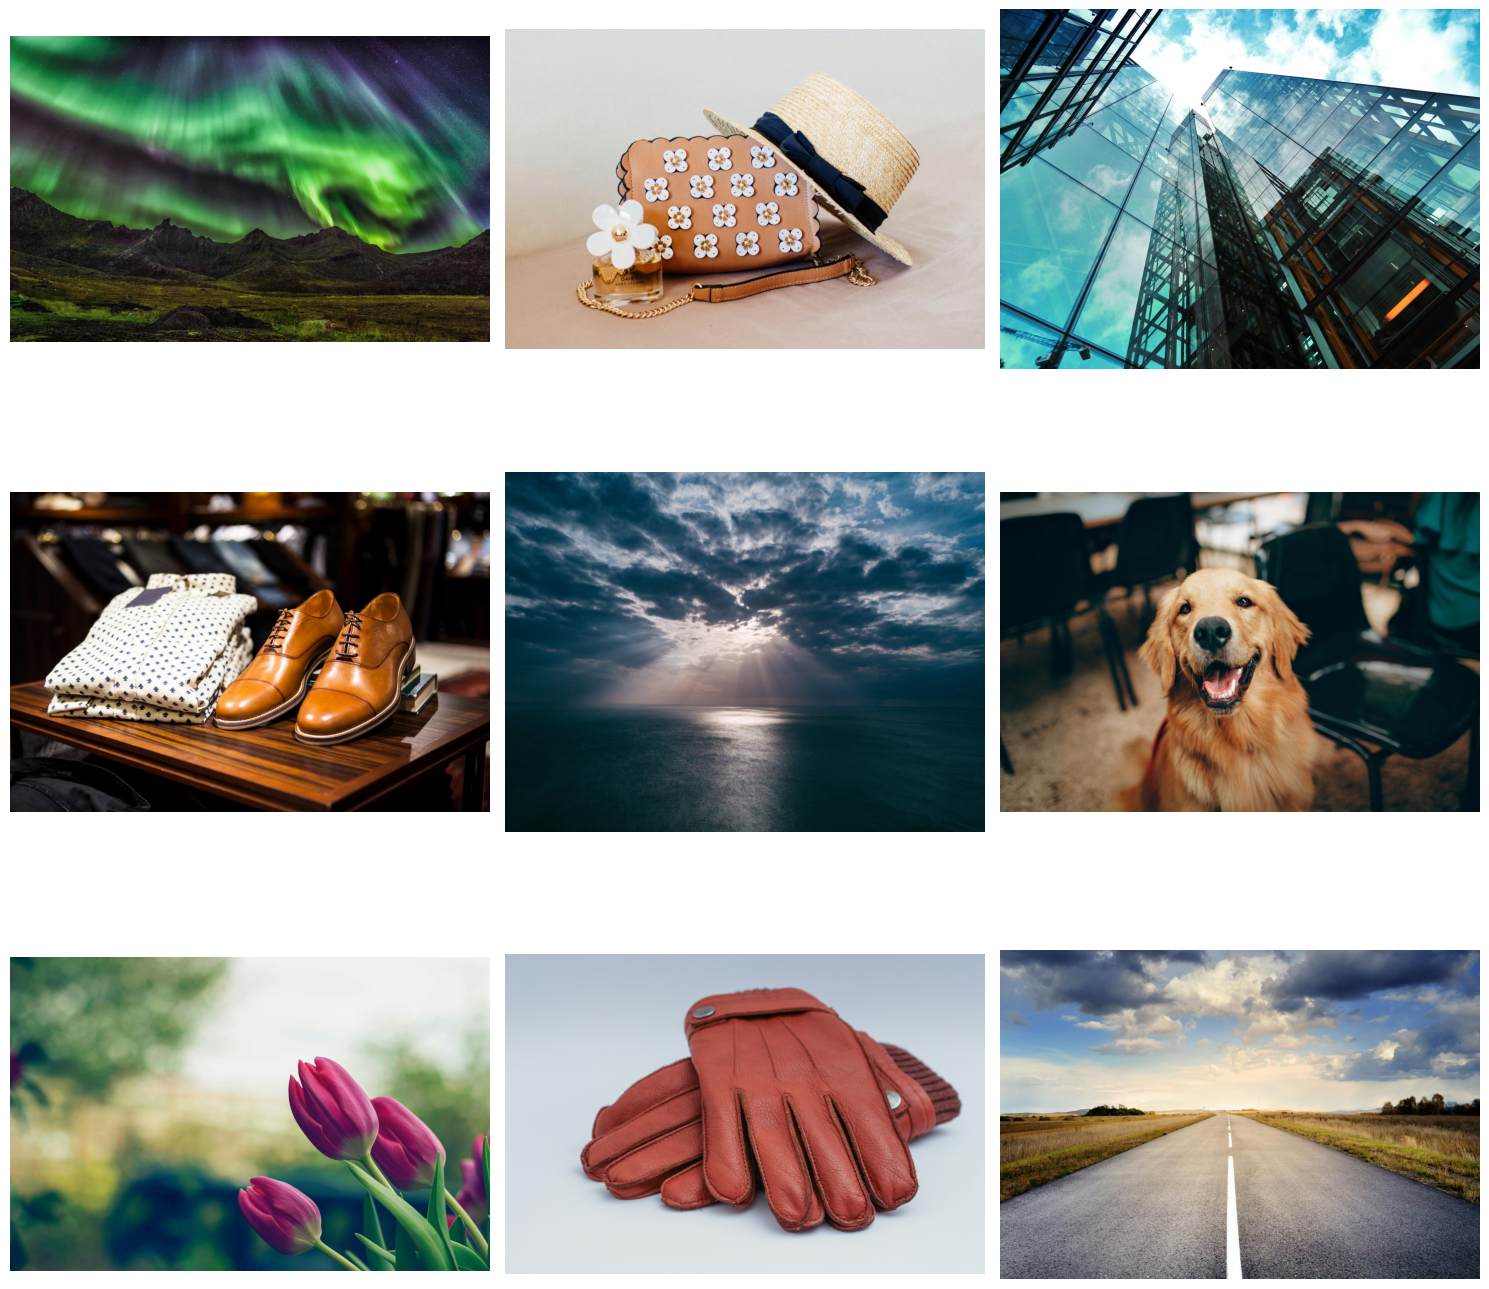

In [15]:
show_image_grid(image_paths, rows=3, cols=3)

Upload images to S3 bucket for processing

In [16]:
!aws s3 sync $IMAGES_DIR s3://$BUCKET/$IMAGES_DIR/ 

upload: images/.ipynb_checkpoints/clothes table-checkpoint.jpg to s3://vrag-s3bucket-fpge7rle535n/images/.ipynb_checkpoints/clothes table-checkpoint.jpg
upload: images/.ipynb_checkpoints/shoes-checkpoint.jpg to s3://vrag-s3bucket-fpge7rle535n/images/.ipynb_checkpoints/shoes-checkpoint.jpg
upload: images/.ipynb_checkpoints/shoes2-checkpoint.jpg to s3://vrag-s3bucket-fpge7rle535n/images/.ipynb_checkpoints/shoes2-checkpoint.jpg
upload: images/.ipynb_checkpoints/road-checkpoint.jpg to s3://vrag-s3bucket-fpge7rle535n/images/.ipynb_checkpoints/road-checkpoint.jpg
upload: images/.ipynb_checkpoints/tree-checkpoint.jpg to s3://vrag-s3bucket-fpge7rle535n/images/.ipynb_checkpoints/tree-checkpoint.jpg
upload: images/.ipynb_checkpoints/bag-checkpoint.jpg to s3://vrag-s3bucket-fpge7rle535n/images/.ipynb_checkpoints/bag-checkpoint.jpg


***

## Image Processing and Encoding
This section transforms your original images into a format suitable for AI processing:

1. Image Resizing:
   - Converts all images to 1280x720 resolution
   - Maintains aspect ratio
   - Optimizes for processing speed and quality

2. Base64 Encoding:
   - Converts images to text format for API compatibility
   - Preserves image data without quality loss
   - Prepares images for Claude-3 model input

**Processing parameters:**
- Target Resolution: 1280x720 pixels
- Output Format: PNG (before encoding)
- Encoding: Base64 UTF-8

**Step-by-step Process:**
1. Load original image
2. Resize to target resolution
3. Convert to PNG format
4. Encode to Base64
5. Save encoded result


Resize images to a standard resolution (1280x720) and encode64 encode them

In [17]:
def resize_and_encode(
    image_path: str,
    output_size: Tuple[int, int] = (1280, 720)
) -> str:
    """
    Resizes an image and converts it to Base64 format.

    Args:
        image_path (str): Path to the source image
        output_size (Tuple[int, int]): Desired output dimensions (width, height)

    Returns:
        str: Base64 encoded string of the processed image

    Raises:
        PIL.UnidentifiedImageError: If the image file cannot be opened
        IOError: If there are issues reading the file
    """
    try:
        with Image.open(image_path) as img:
            img_resized = img.resize(output_size, Image.LANCZOS)
            buffered = BytesIO()
            img_resized.save(buffered, format="PNG")
            img_base64 = base64.b64encode(buffered.getvalue()).decode()
        return img_base64
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        raise

Apply `resize_and_encode` function to all images.

In [18]:
resized_base64s: List[str] = [
    resize_and_encode(image_path)
    for image_path in tqdm(image_paths)
]

100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


<div class="alert alert-warning">
<b>Note:</b> Converting all images to Base64 format. This may take a minute depending on the number and size of images.
</div>

Function to save base64 encoded images.

In [19]:
def save_base64_string(base64_string: str, output_file_path: str) -> None:
    """
    Saves a Base64 encoded string to a file.
    
    Args:
        base64_string (str): The Base64 encoded string to save
        output_file_path (str): Destination file path
    """
    with open(output_file_path, "w") as file:
        file.write(base64_string)

Save processed images.

In [20]:
for base64_img, img_path in zip(resized_base64s, image_paths):
    output_path = os.path.join(
        BASE64_IMAGES_DIR,
        os.path.basename(img_path).replace(".jpg", ".txt")
    )
    save_base64_string(base64_img, output_path)

Upload resized and encoded images to S3

In [21]:
!aws s3 sync $BASE64_IMAGES_DIR s3://$BUCKET/$BASE64_IMAGES_DIR/

upload: base64_images/bag.txt to s3://vrag-s3bucket-fpge7rle535n/base64_images/bag.txt
upload: base64_images/building.txt to s3://vrag-s3bucket-fpge7rle535n/base64_images/building.txt
upload: base64_images/gloves.txt to s3://vrag-s3bucket-fpge7rle535n/base64_images/gloves.txt
upload: base64_images/road.txt to s3://vrag-s3bucket-fpge7rle535n/base64_images/road.txt
upload: base64_images/clothes table.txt to s3://vrag-s3bucket-fpge7rle535n/base64_images/clothes table.txt
upload: base64_images/dog.txt to s3://vrag-s3bucket-fpge7rle535n/base64_images/dog.txt
upload: base64_images/clouds.txt to s3://vrag-s3bucket-fpge7rle535n/base64_images/clouds.txt
upload: base64_images/flower.txt to s3://vrag-s3bucket-fpge7rle535n/base64_images/flower.txt
upload: base64_images/shoes.txt to s3://vrag-s3bucket-fpge7rle535n/base64_images/shoes.txt
upload: base64_images/aurora.txt to s3://vrag-s3bucket-fpge7rle535n/base64_images/aurora.txt
upload: base64_images/shoes2.txt to s3://vrag-s3bucket-fpge7rle535n/ba

***

## Image Description Generation

**What this section does:**

Uses Claude-3 AI model to generate detailed descriptions of each image.

**Process explanation:**
1. Takes Base64 encoded image as input
2. Sends to Claude-3 through AWS Bedrock
3. Receives and processes AI-generated description
4. Stores results for each image

Using AWS Bedrock with Claude-3 model to generate detailed descriptions of each image. We will be inputting the base64 image together with the prompt `Generate a detailed description of the image.` to generate a caption for the image.

In [22]:
def get_image_description(base64_image: str) -> str:
    """
    Generates a description of an image using AWS Bedrock's Claude-3 model.

    Args:
        base64_image (str): Base64 encoded image

    Returns:
        str: Generated description of the image

    Raises:
        KeyError: If the API response structure is unexpected
        Exception: For other API-related errors
    """
    payload = {
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 1000,
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": "image/jpeg",
                            "data": base64_image
                        }
                    },
                    {
                        "type": "text",
                        "text": "Generate a detailed description of the image."
                    }
                ]
            }
        ]
    }

    try:
        response = bedrock_client.invoke_model(
            modelId="anthropic.claude-3-sonnet-20240229-v1:0",
            body=json.dumps(payload)
        )

        response_content = json.loads(response["body"].read().decode("utf-8"))

        if "content" in response_content and len(response_content["content"]) > 0:
            return response_content["content"][0]["text"]

        raise KeyError("Unexpected response structure: 'content' key not found.")

    except Exception as e:
        print(f"Error generating description: {str(e)}")
        raise

<div class="alert alert-warning">
<b>Processing:</b> Generating descriptions for all images. This process may take a couple minutes depending on the number of images as each image needs to be processed by the model.
</div>

Loop through all images and store it in a list.

In [23]:
image_descriptions: List[str] = [
    get_image_description(base64_img)
    for base64_img in tqdm(resized_base64s)
]

100%|██████████| 14/14 [01:37<00:00,  6.99s/it]


Store the images to be shared across notebooks.

In [24]:
%store image_descriptions

Stored 'image_descriptions' (list)


***

## Results Visualization
What this section does:
Displays processed images alongside their AI-generated descriptions for review and validation.

**Visualization details:**
1. Shows original images at specified width (default: 500px)
2. Displays AI-generated description below each image
3. Limits display to specified number of images (default: 5) to prevent notebook overload

In [25]:
def display_results(
    paths: List[str],
    descriptions: List[str],
    num_images: int = 5,
    image_width: int = 500
) -> None:
    """
    Creates a markdown display of images and their descriptions.

    Args:
        paths (List[str]): List of image paths
        descriptions (List[str]): List of image descriptions
        num_images (int): Number of images to display
        image_width (int): Width of displayed images in pixels
    """
    markdown_content = ""
    for path, desc in zip(paths[:num_images], descriptions[:num_images]):
        desc = desc.replace('\n', '')
        markdown_content += f"""
| <img src="{path}" width="{image_width}"/> |
|:----------------:|
| {desc} |

---
"""
    display(Markdown(markdown_content))

In [26]:
display_results(image_paths, image_descriptions)


| <img src="images/aurora.jpg" width="500"/> |
|:----------------:|
| This stunning image captures the breathtaking phenomenon of the Aurora Borealis, also known as the Northern Lights. The night sky is filled with swirling, dancing ribbons of vibrant green light, creating an otherworldly and mesmerizing display. The auroras appear to be cascading down from the heavens, enveloping the landscape with their ethereal glow.Below the celestial spectacle lies a rugged mountainous terrain, with jagged peaks and rocky outcroppings silhouetted against the luminous backdrop. In the foreground, a small meadow or tundra-like area stretches out, dotted with boulders and sparse vegetation, adding a sense of scale and depth to the scene.The image beautifully contrasts the natural wonders of the Earth and the cosmos, showcasing the awe-inspiring beauty of the Northern Lights against the harsh yet stunning landscape. The deep purples and blues of the night sky complement the brilliant greens of the auroras, creating a visually striking and almost otherworldly atmosphere. This image captures the essence of nature's grandeur and the magical wonders that can be witnessed in the remote, pristine regions of our planet. |

---

| <img src="images/bag.jpg" width="500"/> |
|:----------------:|
| The image depicts a stylish fashion accessory set that exudes a summery and floral vibe. The centerpiece is a leather clutch or wristlet with a tan, honey-toned color. The clutch is adorned with white floral appliques made of beads or sequins, creating a delicate and feminine pattern across its surface.Next to the clutch lies a small glass bottle of perfume or eau de toilette, with a white floral design on the bottle, complementing the motif of the clutch. A straw sun hat with a navy blue ribbon wrapped around the crown completes the ensemble, adding a touch of resort chic.Accompanying the accessories is a thin chain strap, likely intended to be attached to the clutch, allowing it to be worn as a crossbody or shoulder bag. The neutral color palette and understated elegance of the pieces suggest a timeless and versatile set that could transition effortlessly from day to evening wear during warm-weather seasons. |

---

| <img src="images/building.jpg" width="500"/> |
|:----------------:|
| This image depicts a striking architectural structure with a modern, glass-and-steel design. The focal point is a towering glass facade that rises towards the sky, reflecting the clouds and blue hues of the surrounding environment. The glass panels are supported by an intricate network of steel beams and trusses, creating a geometric and angular pattern.The building's exterior exhibits a combination of transparency and industrial elements, with the glass panels allowing glimpses into the interior spaces. Some parts of the structure appear to be under construction or renovation, as evidenced by the scaffolding and cranes visible in the image.The overall composition creates a sense of verticality and grandeur, highlighting the impressive engineering and architectural feat. The image conveys a juxtaposition of sleek, modern design and the rawness of construction materials, showcasing the process of transforming a vision into a tangible structure. |

---

| <img src="images/clothes table.jpg" width="500"/> |
|:----------------:|
| The image depicts a display of stylish men's fashion accessories, likely in a clothing store or boutique setting. The focus is on a pair of beautifully crafted tan leather dress shoes with laces, placed on a wooden display platform. The shoes appear to be of high quality and have a polished, sophisticated look.Next to the shoes, there are folded dress shirts or button-down shirts with a dotted or micro-pattern print in shades of blue and white. The shirts are neatly arranged, showcasing their fine fabric and elegant design.The background is blurred, but it appears to be a clothing store interior with racks or shelves displaying additional merchandise. The lighting creates a warm and inviting ambiance, highlighting the textures and details of the displayed items.The image exudes a sense of refined taste and attention to detail, showcasing the craftsmanship and style associated with men's formal or business attire. |

---

| <img src="images/clouds.jpg" width="500"/> |
|:----------------:|
| The image depicts a dramatic and awe-inspiring sky over a vast body of water. The clouds are dark and ominous, with shades of deep blue and gray, creating a moody and atmospheric scene. However, amidst the dense clouds, rays of sunlight pierce through, casting a striking and ethereal illumination on the water below.The sunbeams create a radiant path across the water's surface, reflecting the golden hues of the sun's rays and creating a mesmerizing contrast with the darker surroundings. The water itself appears calm and reflective, mirroring the intense clouds above and amplifying the visual impact of the scene.The composition of the image is striking, with the horizon line dividing the frame into two distinct halves – the dramatic sky above and the serene water below. This arrangement creates a sense of balance and harmony, despite the contrasting elements of light and dark, calm and turbulence.Overall, the image conveys a powerful sense of nature's majesty, showcasing the interplay between light and shadow, tranquility and intensity, and inviting the viewer to appreciate the breathtaking beauty of the natural world. |

---


<div class="alert alert-success">
<b>🎉 Congratulations!</b> You have successfully completed the image processing notebook!

Key accomplishments:
- ✅ Processed and resized all images
- ✅ Generated Base64 encodings
- ✅ Stored data in S3
- ✅ Generated image descriptions using Claude-3
- ✅ Created visualization of results

You can now proceed to the next notebook in the series.
</div>